# Использование регрессии для прогнозирования тарифов на такси

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/taxi-fares.csv", parse_dates=["pickup_datetime"])
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1
...,...,...,...,...,...,...,...,...
55363,2011-09-18 19:58:26.0000004,49.8,2011-09-18 19:58:26+00:00,-73.954218,40.781272,-73.790650,40.644147,1
55364,2011-02-05 16:22:00.000000112,9.7,2011-02-05 16:22:00+00:00,-74.000117,40.732792,-73.974612,40.749842,1
55365,2010-06-14 09:49:26.0000005,8.9,2010-06-14 09:49:26+00:00,-73.994161,40.751109,-73.973510,40.757730,1
55366,2015-06-08 21:54:03.0000002,3.5,2015-06-08 21:54:03+00:00,-73.995331,40.759766,-73.990479,40.766396,1


In [3]:
%matplotlib inline
import matplotlib as plt
import seaborn as sns
# sns.set()

<Axes: xlabel='passenger_count', ylabel='count'>

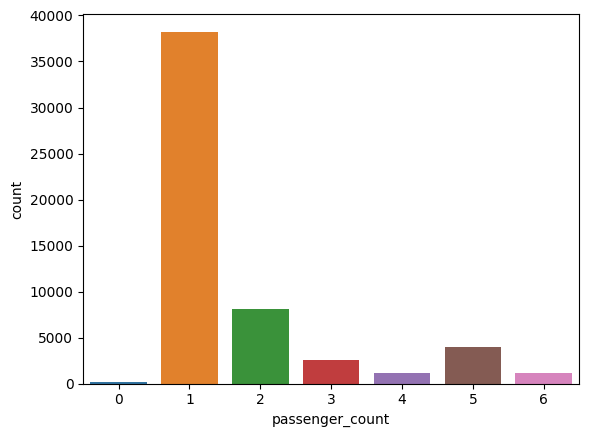

In [4]:
import warnings
warnings.filterwarnings("ignore")

sns.countplot(x=df["passenger_count"])

In [5]:
# Только один пассажир
df = df[df["passenger_count"] == 1]

df = df.drop(columns=["key", "passenger_count"])
df.shape

(38233, 6)

In [6]:
corr_matrix = df.corr()
corr_matrix

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
fare_amount,1.000000,0.115992,0.015742,-0.015915,0.020438,-0.021711
pickup_datetime,0.115992,1.000000,0.011167,-0.013109,0.011467,-0.013421
pickup_longitude,0.015742,0.011167,1.000000,-0.974220,0.948185,-0.933444
pickup_latitude,-0.015915,-0.013109,-0.974220,1.000000,-0.933960,0.958464
dropoff_longitude,0.020438,0.011467,0.948185,-0.933960,1.000000,-0.978209
dropoff_latitude,-0.021711,-0.013421,-0.933444,0.958464,-0.978209,1.000000


In [7]:
# Матрица корреляции значений
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
pickup_datetime      0.115992
dropoff_longitude    0.020438
pickup_longitude     0.015742
pickup_latitude     -0.015915
dropoff_latitude    -0.021711
Name: fare_amount, dtype: float64

In [8]:
# Создание дополнительных признаков из существующих
from math import sqrt

for i, row in df.iterrows():
    dt = row["pickup_datetime"]
    df.at[i, "day_of_week"] = dt.weekday()
    df.at[i, "pickup_time"] = dt.hour
    x = (row["dropoff_longitude"] - row["pickup_longitude"]) * 54.6
    y = (row["dropoff_latitude"] - row["pickup_latitude"]) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, "distance"] = distance

In [9]:
df.drop(columns=["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], inplace=True)
df

,fare_amount,day_of_week,pickup_time,distance
0,7.0,6.0,17.0,0.720497
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
...,...,...,...,...
55363,49.8,6.0,19.0,13.010833
55364,9.7,5.0,16.0,1.822990
55365,8.9,0.0,9.0,1.216580
55366,3.5,0.0,21.0,0.528645


In [16]:
df = df[(df["distance"] > 1.0) & (df["distance"] < 10.0)]
df = df[(df["fare_amount"] > 0.0) & (df["fare_amount"] < 50.0)]

In [18]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount    1.000000
distance       0.851913
day_of_week   -0.003570
pickup_time   -0.023085
Name: fare_amount, dtype: float64

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

x = df.drop(columns=["fare_amount"])
y = df["fare_amount"]

In [20]:
model = LinearRegression()
cross_val_score(model, x, y, cv=5).mean()

0.7258845061910318

In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
cross_val_score(model, x, y, cv=5).mean()

0.7056142291526881

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
cross_val_score(model, x, y, cv=5).mean()

0.7504886125515002

In [23]:
model.fit(x, y)

model.predict(pd.DataFrame({"day_of_week": [4], "pickup_time": [17], "distance": [2.0]}))

array([11.49105571])

In [24]:
model.predict(pd.DataFrame({"day_of_week": [5], "pickup_time": [17], "distance": [2.0]}))

array([10.95309995])